In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

!pip freeze > requirements. txt

In [2]:
data_filename = 'Sales Detail.xlsx'
sheet_name = 'Online Retail'

In [3]:
# Read dataset
df = pd.read_excel('../data/'+ data_filename,
                   sheet_name=sheet_name)

<hr>

## Pre Processing

In [4]:
# Remove unnecesary columns
del df['Unnamed: 8']

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
# Format columns
## Numeric
for col in ['Quantity','UnitPrice']:
    df[col]=pd.to_numeric(df[col], errors='coerce')
    
## Date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d %H:%M:%s', errors = 'coerce')
df.head()

df['CustomerID'] = df['CustomerID'].map(int).map(str)

In [7]:
# Create time features
df['period'] = df['InvoiceDate'].dt.year*100 + df['InvoiceDate'].dt.month
df['date_short'] = pd.to_datetime(df['InvoiceDate'].map(str).str[:10], format='%Y-%m-%d', errors = 'coerce')

In [8]:
# standarize Description
df['Description'] = df['Description'].map(str).str.lower()
df.loc[df['Description']=='nan', 'Description']=np.NaN

In [9]:
# Create useful features
df['Quarter'] = 'Q_' + np.ceil((df['period']%100)/3).map(int).map(str)
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

<hr>

## EDA

In [10]:
# Count nulls
df.count() / df.shape[0]

InvoiceNo      1.000000
StockCode      1.000000
Description    0.997317
Quantity       1.000000
InvoiceDate    1.000000
UnitPrice      1.000000
CustomerID     1.000000
Country        1.000000
period         1.000000
date_short     1.000000
Quarter        1.000000
TotalPrice     1.000000
dtype: float64

### Unit Price

In [11]:
df['UnitPrice'].describe(percentiles=[i/10 for i in range(1,10)])

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
10%           0.630000
20%           0.850000
30%           1.250000
40%           1.650000
50%           2.080000
60%           2.550000
70%           3.750000
80%           4.950000
90%           7.950000
max       38970.000000
Name: UnitPrice, dtype: float64

In [12]:
# Looking for negative values
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,period,date_short,Quarter,TotalPrice
532619,A563186,B,adjust bad debt,1,2011-08-12 14:51:00,-11062.06,15287,United Kingdom,201108,2011-08-12,Q_3,-11062.06
532620,A563187,B,adjust bad debt,1,2011-08-12 14:52:00,-11062.06,15287,United Kingdom,201108,2011-08-12,Q_3,-11062.06


In [13]:
# Data w UnitPrice = 0
df[df['UnitPrice']==0]['Description'].value_counts(dropna=False, normalize=True)

NaN                      0.578131
check                    0.064414
damaged                  0.023062
?                        0.018688
damages                  0.018290
                           ...   
wrongly sold as sets     0.000398
found in w/hse           0.000398
wrongly sold sets        0.000398
piggy bank retrospot     0.000398
website fixed            0.000398
Name: Description, Length: 361, dtype: float64

__Observations:__  
- 80% of the products have a UnitPrice between 0.85 and 7.95 USD (not expensive items)
- UnitPrice has some values equal to 0 and also 2 rows with negative values.  
- When looking at 0 in UnitPrice, most of the entries don't have a description
<hr>

### Sales Frequency

Distribution of days from last sale:


,days_from_last_sale,days_from_last_sale
NaN,4372,0.223403
1.0,830,0.042412
7.0,652,0.033316
6.0,545,0.027849
2.0,538,0.027491
...,...,...
310.0,1,0.000051
352.0,1,0.000051
339.0,1,0.000051
332.0,1,0.000051


count    15198.000000
mean        38.489407
std         50.529105
min          1.000000
10%          3.000000
20%          6.000000
30%          9.000000
40%         14.000000
50%         20.000000
60%         29.000000
70%         40.000000
80%         59.000000
90%         98.000000
max        366.000000
Name: days_from_last_sale, dtype: float64

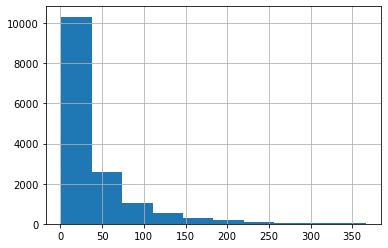

In [14]:
# Get unique dates of sales for every customer
tmp = df[['CustomerID','date_short']].drop_duplicates()
tmp.sort_values(by=['CustomerID','date_short'], ascending=True, inplace=True)

# Get days from last sale
tmp['days_from_last_sale'] = (tmp['date_short'] - tmp.groupby('CustomerID')['date_short'].shift(1)).dt.days

#Show distribution
print('Distribution of days from last sale:')
display(pd.concat([tmp['days_from_last_sale'].value_counts(dropna=False),
                   tmp['days_from_last_sale'].value_counts(dropna=False, normalize=True)], axis=1))
display(tmp['days_from_last_sale'].describe(percentiles = [i/10 for i in range(1,10)]))
tmp['days_from_last_sale'].hist()
plt.show()

__Observations:__  
- ~20% of the sales were "new Customers" (had not bought before).
- Looking at "old Customers" (at least 1 sale before) , 50% of them bought at most in the next 20 days.
- We could consider predicting sales not monthly but for the next 2 weeks.
<hr>

In [15]:
# Number of months when there was a sale
# Relative
df.groupby('CustomerID').agg({'period':'nunique'})['period'].value_counts(dropna=False,normalize=True)

1     0.359561
2     0.206313
3     0.127173
4     0.088747
5     0.064730
6     0.041629
7     0.024474
8     0.021729
9     0.018527
10    0.013952
11    0.012580
13    0.011208
12    0.009378
Name: period, dtype: float64

In [16]:
# Relative Cumulated
df.groupby('CustomerID').agg({'period':'nunique'})['period'].value_counts(dropna=False,normalize=True).cumsum()

1     0.359561
2     0.565874
3     0.693047
4     0.781793
5     0.846523
6     0.888152
7     0.912626
8     0.934355
9     0.952882
10    0.966834
11    0.979414
13    0.990622
12    1.000000
Name: period, dtype: float64

__Observations:__  
- ~35% of Customers bought only once.  
- ~70% of Customers bought products at most in 3 different months.  
<hr>

### Operation in many countries

In [17]:
df.groupby('CustomerID').agg({'Country':'nunique'})['Country'].value_counts()

1    4363
2       8
9       1
Name: Country, dtype: int64

Most Customers have operations in only 1 country. Only 8 Customers have operations in 2 countries and just 1 in more than that

### Total Amount of sale and Number of sales by Customer

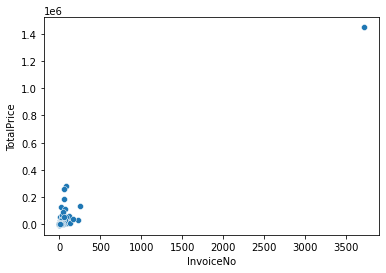

count    4372.000000
mean        5.924062
std        56.850047
min         1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         2.000000
50%         3.000000
60%         4.000000
70%         5.000000
80%         7.000000
90%        11.000000
max      3713.000000
Name: InvoiceNo, dtype: float64

count    4.372000e+03
mean     2.229586e+03
std      2.336635e+04
min     -4.287630e+03
10%      1.460220e+02
20%      2.343920e+02
30%      3.373700e+02
40%      4.654120e+02
50%      6.485500e+02
60%      9.096680e+02
70%      1.312788e+03
80%      2.003560e+03
90%      3.514766e+03
max      1.448167e+06
Name: TotalPrice, dtype: float64

In [18]:
# Understand data by CustomerID, Country and period
#df_grouped = df.groupby(['CustomerID', 'Country', 'period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df.groupby(['CustomerID']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
sns.scatterplot(data = df_grouped, x = 'InvoiceNo', y='TotalPrice', )
plt.show()
display(df_grouped['InvoiceNo'].describe(percentiles=[i/10 for i in range(1,10)]))
display(df_grouped['TotalPrice'].describe(percentiles=[i/10 for i in range(1,10)]))

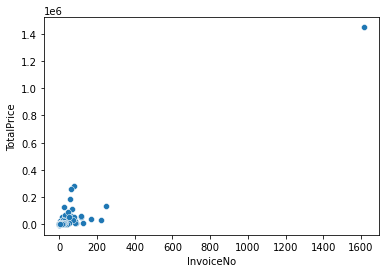

count    4371.000000
mean        5.444521
std        26.077982
min         1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         2.000000
50%         3.000000
60%         4.000000
70%         5.000000
80%         7.000000
90%        11.000000
max      1615.000000
Name: InvoiceNo, dtype: float64

count    4.371000e+03
mean     2.230096e+03
std      2.336900e+04
min     -4.287630e+03
10%      1.468500e+02
20%      2.346000e+02
30%      3.374400e+02
40%      4.655500e+02
50%      6.486900e+02
60%      9.099600e+02
70%      1.313100e+03
80%      2.003850e+03
90%      3.515680e+03
max      1.448167e+06
Name: TotalPrice, dtype: float64

In [19]:
# Understand data by CustomerID, Country and period
#df_grouped = df.groupby(['CustomerID', 'Country', 'period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df[df['UnitPrice']!=0].groupby(['CustomerID']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
sns.scatterplot(data = df_grouped, x = 'InvoiceNo', y='TotalPrice', )
plt.show()
display(df_grouped['InvoiceNo'].describe(percentiles=[i/10 for i in range(1,10)]))
display(df_grouped['TotalPrice'].describe(percentiles=[i/10 for i in range(1,10)]))

__Comments:__
- There is a Customer outlier much more that the others in terms of volume of sale and number of sales.

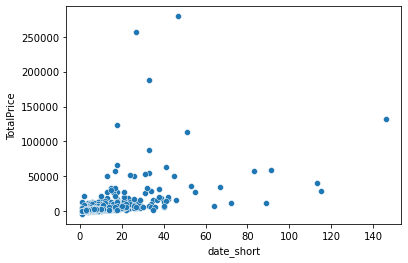

count    4370.000000
mean        4.414416
std         6.675634
min         1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         2.000000
50%         2.000000
60%         3.000000
70%         4.000000
80%         6.000000
90%         9.100000
max       146.000000
Name: date_short, dtype: float64

count      4370.000000
mean       1899.217523
std        8221.148205
min       -4287.630000
10%         146.758000
20%         234.548000
30%         337.410000
40%         465.458000
50%         648.550000
60%         909.522000
70%        1312.372000
80%        2002.690000
90%        3507.454000
max      279489.020000
Name: TotalPrice, dtype: float64

In [20]:
# Understand data by CustomerID, Country and period
#df_grouped = df.groupby(['CustomerID', 'Country', 'period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df[df['UnitPrice']!=0].groupby(['CustomerID']).agg({'date_short':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df_grouped[df_grouped['date_short']<200] #Removing outlier
sns.scatterplot(data = df_grouped, x = 'date_short', y='TotalPrice', )
plt.show()
display(df_grouped['date_short'].describe(percentiles=[i/10 for i in range(1,10)]))
display(df_grouped['TotalPrice'].describe(percentiles=[i/10 for i in range(1,10)]))

__Comments:__
- After removing the outlier Customer we can see the following:
    - Most of the customers buy less than 40 times and  less than 50k in the year.
    - There is a small group of Customers ("The most frequent") that buy more than 40 times but less than 100k a year
    - There is a small group of Customers ("The most valuable") that buy less than 40 times but more than 100k a year

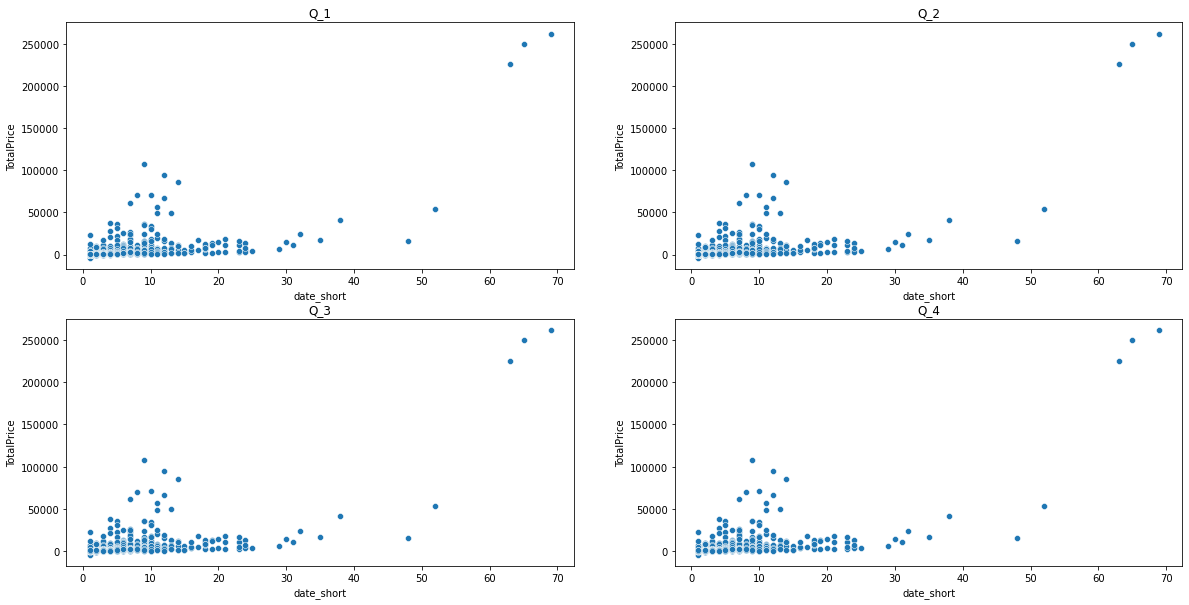

In [21]:
# Understand data by CustomerID and Country for each Q
df_grouped = df[df['UnitPrice']!=0].groupby(['CustomerID','Quarter']).agg({'date_short':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df_grouped[df_grouped['date_short']<75] #Removing outlier

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plt.title('frequency vs Total Sales by CustomerID and Q')
ax = ax.reshape(-1)
for idx,q in enumerate(df_grouped['Quarter'].unique()):
    sns.scatterplot(data = df_grouped, x='date_short', y='TotalPrice', ax=ax[idx])
    ax[idx].set_title(q)
plt.show()    
        
#sns.scatterplot(data = df_grouped, x = 'Quantity', y='TotalPrice', )

__Observations:__  
- This graphs were created in order to see if the patterns of volume and frequency are constant over the time
<hr>

In [22]:
# Analysing Sales by Quarter

## Get data by Quarter
df_grouped = df[df['TotalPrice']!=0].groupby(['CustomerID','Quarter']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()

for q in df_grouped['Quarter'].unique():
    print(q)
    print('Top 10 Customers:')
    print(df_grouped[df_grouped['Quarter']==q].sort_values(by='TotalPrice', ascending=False)[:10])
    if q=='Q_1':
        customers = df_grouped[df_grouped['Quarter']==q].sort_values(by='TotalPrice', ascending=False)[:10][['CustomerID']]
    else:
        customers = customers.merge(df_grouped[df_grouped['Quarter']==q].sort_values(by='TotalPrice', ascending=False)[:10][['CustomerID']], how='inner', on ='CustomerID')
    print('\n')
print('List of customers in top10 for every Q')
display(customers)

Q_1
Top 10 Customers:
     CustomerID Quarter  InvoiceNo  Quantity  TotalPrice
4522      15287     Q_1        381     84637   249744.85
3566      14646     Q_1         13     50696    70691.54
112       12415     Q_1          5     23304    37674.04
2789      14156     Q_1         14     14224    32620.92
7732      17450     Q_1          7     11023    30988.62
5242      15769     Q_1          7     12832    23089.68
5205      15749     Q_1          2      9014    22998.40
7806      17511     Q_1         11     12476    18723.13
8685      18102     Q_1          4      3964    17444.80
4569      15311     Q_1         27     11040    16477.35


Q_2
Top 10 Customers:
     CustomerID Quarter  InvoiceNo  Quantity  TotalPrice
4523      15287     Q_2        403     63619   225351.66
8686      18102     Q_2         13     13361    61163.93
3567      14646     Q_2         18     40008    56673.69
113       12415     Q_2          6     23726    36042.97
7733      17450     Q_2          9     112

,CustomerID
0,15287
1,14646
2,17450
3,18102


<AxesSubplot:xlabel='Quantity', ylabel='TotalPrice'>

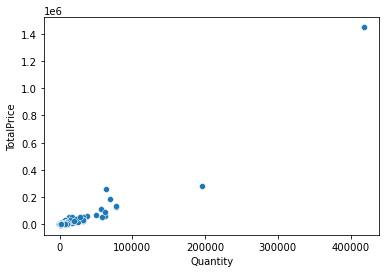

In [23]:
# Understand data by CustomerID, Country and period
#df_grouped = df.groupby(['CustomerID', 'Country', 'period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
 
df_grouped = df[(df['TotalPrice']!=0)].groupby(['CustomerID']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
sns.scatterplot(data = df_grouped, x = 'Quantity', y='TotalPrice', )


<AxesSubplot:xlabel='Quantity', ylabel='TotalPrice'>

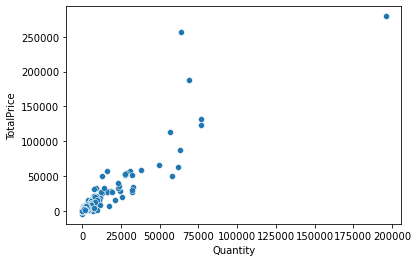

In [24]:
# Understand data by CustomerID, Country and period
#df_grouped = df.groupby(['CustomerID', 'Country', 'period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
 
df_grouped = df[(df['TotalPrice']!=0)].groupby(['CustomerID']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
df_grouped = df_grouped[df_grouped['Quantity']<200000]
sns.scatterplot(data = df_grouped, x = 'Quantity', y='TotalPrice', )


<hr>

# Dataset creation

In this section we will create a dataset that will help not only with the modelling but with the prospection.  
Also, this dataset is a "more general purpose" dataset that can also be used by business analyst to analyze sales.  
For every CustomerID "Active" in the corresponding period (with at least 1 sale in the last 6 months) we will get the amount of the sales of the last 6 months

In [25]:
# Group data by CustomerID and period (month)
data = df.groupby(['CustomerID','period']).agg({'InvoiceNo':'nunique', 'Quantity':'sum' , 'TotalPrice':'sum'}).reset_index()
print(data.shape)
display(data.sample(10))

(13685, 5)


,CustomerID,period,InvoiceNo,Quantity,TotalPrice
9057,16218,201111,1,336,449.20
5710,14719,201110,2,167,307.27
9741,16552,201104,1,180,284.44
12544,17752,201012,1,192,80.64
8283,15864,201102,1,-4,-13.90
1715,13027,201104,1,5040,2016.00
909,12686,201012,1,107,89.14
1460,12930,201109,1,144,194.24
13632,18259,201012,1,116,376.30
5082,14466,201108,1,139,234.75


In [26]:
# Get all periods for every CustomerID
data = data.pivot_table(values = 'TotalPrice', index = 'CustomerID', columns ='period').reset_index().melt(id_vars = 'CustomerID', var_name='period', value_name = 'TotalPrice' ) 
print(data.shape)
display(data.sample(10))

(56836, 3)


,CustomerID,period,TotalPrice
35397,12877,201108,100.4
1612,14523,201012,NaN
7701,16846,201101,NaN
31811,13971,201107,NaN
30915,12723,201107,NaN
21588,17914,201104,NaN
22334,12951,201105,163.6
8354,17749,201101,NaN
48775,13243,201111,NaN
2998,16401,201012,NaN


In [27]:
# Get past sales
data.sort_values(by=['CustomerID', 'period'], ascending=True)
data_grouped = data.groupby('CustomerID')
for i in range(1,7):
    data[f'sales_{i}'] = data_grouped['TotalPrice'].shift(i)
print(data.shape)
display(data.sample(10))    

(56836, 9)


,CustomerID,period,TotalPrice,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6
53985,14408,201112,NaN,308.22,NaN,301.80,781.19,NaN,509.68
19362,14885,201104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55043,15825,201112,NaN,NaN,NaN,NaN,NaN,NaN,532.94
43358,17789,201109,NaN,NaN,NaN,NaN,NaN,NaN,225.90
33199,15844,201107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16198,16513,201103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39729,12826,201109,234.0,NaN,NaN,114.92,NaN,NaN,NaN
28511,15428,201106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40318,13643,201109,171.5,NaN,NaN,87.90,NaN,NaN,NaN
34133,17125,201107,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Filter data only to look at records where there is at least 1 sale in last 6 months
data['n_sales_last_6_m'] = (data[[f'sales_{i}' for i in range(1,7)]].count(axis=1)>0)*1
print(data.shape)
data = data[data['n_sales_last_6_m']==1]
print(data.shape)
display(data.sample(10))

(56836, 10)
(29635, 10)


,CustomerID,period,TotalPrice,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,n_sales_last_6_m
26874,13185,201106,NaN,NaN,NaN,71.40,NaN,NaN,NaN,1
32219,14527,201107,611.16,513.80,456.33,296.71,338.25,374.44,739.23,1
50059,15024,201111,593.60,222.11,NaN,157.53,NaN,NaN,NaN,1
29579,16875,201106,NaN,NaN,-4.95,NaN,436.29,326.95,NaN,1
32016,14245,201107,NaN,-4.12,686.40,NaN,995.20,NaN,NaN,1
11979,16727,201102,NaN,NaN,272.82,NaN,NaN,NaN,NaN,1
7297,16306,201101,175.15,68.10,NaN,NaN,NaN,NaN,NaN,1
33875,16770,201107,NaN,NaN,NaN,124.98,NaN,NaN,269.30,1
30704,12471,201107,940.46,NaN,859.30,668.88,872.50,1193.90,587.75,1
31481,13508,201107,NaN,NaN,NaN,110.97,NaN,NaN,NaN,1


In [29]:
# Save dataset as a lookuptable and for other purposes
data.to_csv('../data/sales_by_customer_and_period.csv', index=False,)

In [30]:
# Save a sample for prediction
data[data['period']==201112][['CustomerID','period']].sample(50).to_csv('../data/data_sample_for_prediction.csv', index=False,)

__Notes__:  
- I recommend saving tables as .parquet files than .csv. (because the speed of reading and it keeps the datatypes of columns)
- However, I was getting trouble with pyarrow and dependencies.  
- As I do not want to spend much time trying to solve this issue but working on the model, I have saved the table as .csv file

<hr>

# Feature Engineering

__Comments:__
- This sections is aimed to create relevant features for the model to help finding patterns for predicting probability of making a sale and the amount of that sale  
- Because there are little features in the dataset and I do not recommend creating a lot of redundant variables, I will use "expert opinion" to create those relevant features in mention.
- The expert opinion is as follows: To predict if there will be a sale in the next month, I would like to know:
    - What was the last amount of sale (monthly)
    - how much is the sale's mean for that CustomerID
    - What is the ratio between last sale and the mean
    - How often this customer buys (in month terms)
    - When was the last month this customer bought
    - What is the the ratio between the months from last sale and the mean frequency

In [31]:
# Get information about last sale amount
data['sales_mean_6_m'] = data[[f'sales_{i}' for i in range(1,7)]].mean(axis=1)

data['last_sale'] = data[[f'sales_{i}' for i in range(1,7)]].fillna(method='bfill', axis=1).iloc[:, 0]
data['last_sale_over_6m_mean'] = (data['last_sale'] / data['sales_mean_6_m']).fillna(0)
data.loc[data['sales_mean_6_m']==0,'last_sale_over_6m_mean']=0

data['last_sale_over_total'] = data['last_sale'] / data[[f'sales_{i}' for i in range(1,7)]].sum(axis=1)
data.loc[data[[f'sales_{i}' for i in range(1,7)]].sum(axis=1)==0,'last_sale_over_total']=0

# Get information about last sale date
data['sales_cadence'] = data[[f'sales_{i}' for i in range(1,7)]].fillna(method='bfill', axis=1).count(axis=1)/data[[f'sales_{i}' for i in range(1,7)]].count(axis=1)
data['months_from_last_sale'] = data[[f'sales_{i}' for i in range(1,7)]].fillna(method='ffill', axis=1).isnull().sum(axis=1)
data['sales_cadence_deviation'] = data['months_from_last_sale'] - data['sales_cadence']
display(data.sample(10))

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,CustomerID,period,TotalPrice,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,n_sales_last_6_m,sales_mean_6_m,last_sale,last_sale_over_6m_mean,last_sale_over_total,sales_cadence,months_from_last_sale,sales_cadence_deviation
18368,13512,201104,NaN,251.21,NaN,NaN,NaN,NaN,NaN,1,251.210000,251.21,1.000000,1.000000,1.000000,0,-1.000000
22304,12913,201105,NaN,NaN,134.97,313.80,NaN,417.62,NaN,1,288.796667,134.97,0.467353,0.155784,1.666667,1,-0.666667
38071,16531,201108,199.70,NaN,NaN,NaN,NaN,NaN,245.91,1,245.910000,245.91,1.000000,1.000000,6.000000,5,-1.000000
31513,13555,201107,NaN,NaN,1590.05,NaN,NaN,NaN,NaN,1,1590.050000,1590.05,1.000000,1.000000,2.000000,1,-1.000000
39137,17997,201108,NaN,954.19,322.53,NaN,NaN,NaN,NaN,1,638.360000,954.19,1.494752,0.747376,1.000000,0,-1.000000
26981,13329,201106,NaN,NaN,NaN,NaN,NaN,NaN,255.60,1,255.600000,255.60,1.000000,1.000000,6.000000,5,-1.000000
20724,16728,201104,102.44,224.49,NaN,NaN,NaN,NaN,NaN,1,224.490000,224.49,1.000000,1.000000,1.000000,0,-1.000000
39950,13134,201109,890.84,NaN,NaN,360.04,NaN,489.75,NaN,1,424.895000,360.04,0.847362,0.423681,2.500000,2,-0.500000
42214,16216,201109,NaN,NaN,NaN,NaN,NaN,NaN,914.93,1,914.930000,914.93,1.000000,1.000000,6.000000,5,-1.000000
26297,12427,201106,NaN,NaN,NaN,NaN,NaN,NaN,246.55,1,246.550000,246.55,1.000000,1.000000,6.000000,5,-1.000000


<hr>

# Modelling

## Frequency model

The target for this model is to predict just a binary decision:  
- 0: The customer will not buy this month
- 1: The customer will buy

In [32]:
data_bk = data.copy()

In [33]:
data = data_bk.copy()

In [34]:
# Frequency
data['target'] = data['TotalPrice'].notnull()*1

In [35]:
# Target ratio
data['target'].mean()

0.3029188459591699

In [36]:
from sklearn.metrics import plot_confusion_matrix

In [37]:
columns = ['sales_mean_6_m','last_sale','last_sale_over_6m_mean','sales_cadence',
           'months_from_last_sale','sales_cadence_deviation','last_sale_over_total']
X = data[columns]
y = data['target'].map(float)

In [38]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import LinearSVC

LogisticRegression()
Accuracy Train: 68.39%
Accuracy Test:  68.47%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


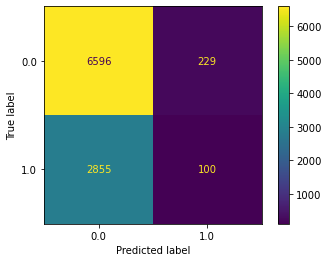

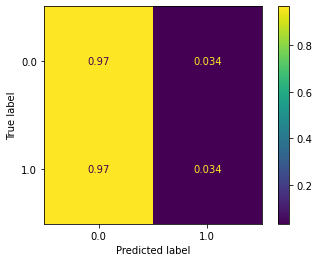

**************************************************

RidgeClassifier()
Accuracy Train: 72.40%
Accuracy Test:  72.96%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


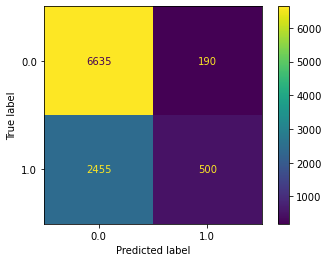

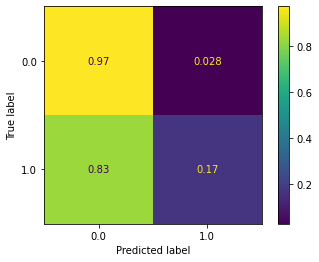

**************************************************

DecisionTreeClassifier(max_depth=7)
Accuracy Train: 75.17%
Accuracy Test:  73.79%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


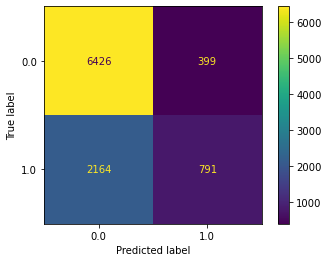

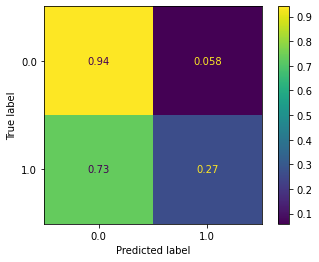

**************************************************

RandomForestClassifier(max_depth=7, n_estimators=5)
Accuracy Train: 75.40%
Accuracy Test:  74.15%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


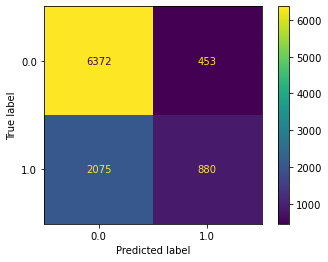

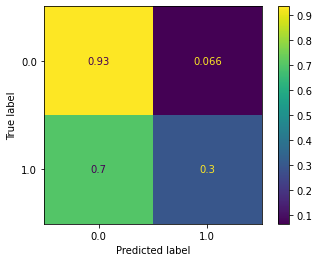

**************************************************

AdaBoostClassifier()
Accuracy Train: 74.36%
Accuracy Test:  74.21%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


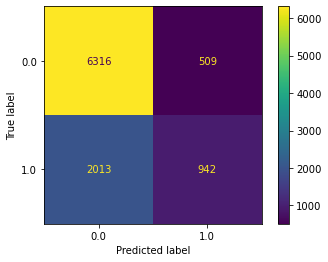

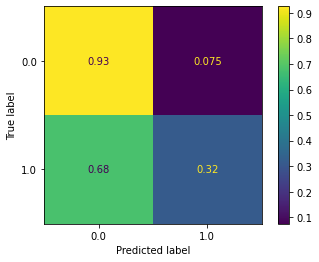

**************************************************

LinearSVC()
Accuracy Train: 68.93%
Accuracy Test:  69.23%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


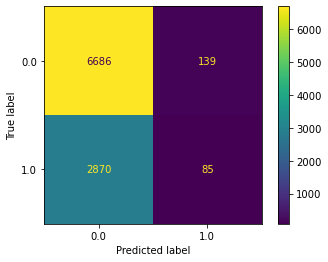

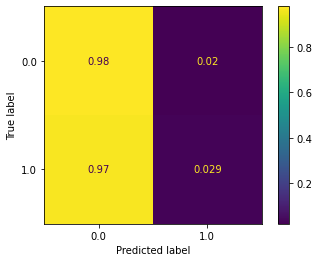

**************************************************



In [40]:
# Evaluate various models 
## Define list of models to be evaluated

models = []
models.append(LogisticRegression())
models.append(RidgeClassifier())
models.append(DecisionTreeClassifier(max_depth=7))
models.append(RandomForestClassifier(n_estimators=5, max_depth=7 ))
models.append(AdaBoostClassifier( ))
models.append(LinearSVC())
for model in models:
    # Train the model
    print(model)
    clf = model
    clf = clf.fit(X_train, y_train)
    
    # Show results/metrics
    from sklearn.metrics import accuracy_score
    print('Accuracy Train: {:.2%}'.format(accuracy_score(y_train, clf.predict(X_train))))
    print('Accuracy Test:  {:.2%}'.format(accuracy_score(y_test, clf.predict(X_test))))
    plot_confusion_matrix(clf, X_test, y_test) 
    plot_confusion_matrix(clf, X_test, y_test, normalize='true') 
    plt.show()
    print('*'*50+'\n')

__Observations:__  
    - Tree based models perform better than linear and ensembled perform better than simple tree based.
    - However, looking at confussion matrix we can see that the performance of the models are basically biased to the class "0" (customers that didn't buy)
    - After seeing this, we'll try undersampling the training dataset to try to fix that bias

In [41]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Define sampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print(Counter(y_train))

Counter({0.0: 6022, 1.0: 6022})


LogisticRegression()
Accuracy Train: 50.00%
Accuracy Test:  69.79%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function 

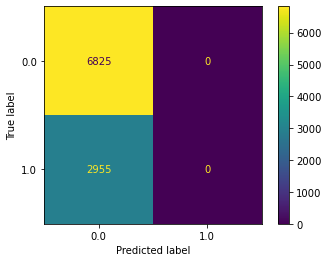

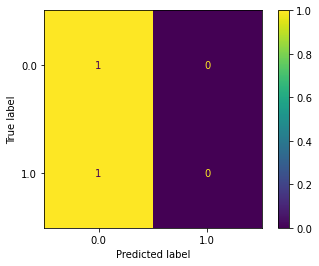

**************************************************

RidgeClassifier()
Accuracy Train: 64.10%
Accuracy Test:  64.40%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


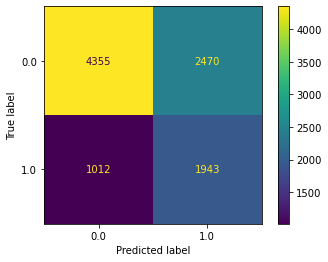

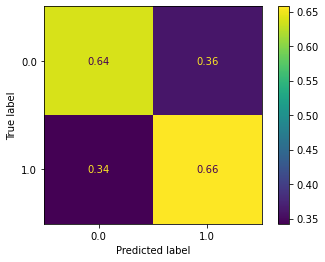

**************************************************

DecisionTreeClassifier(max_depth=7)
Accuracy Train: 67.55%
Accuracy Test:  67.47%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


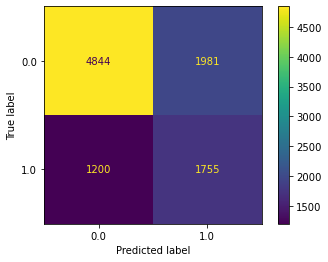

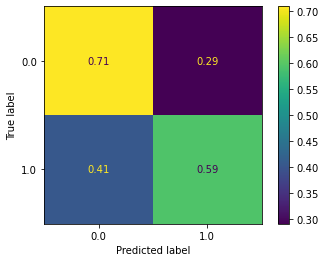

**************************************************

RandomForestClassifier(max_depth=7, n_estimators=5)
Accuracy Train: 68.76%
Accuracy Test:  68.32%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


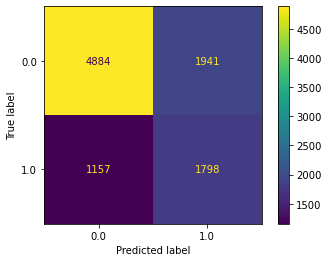

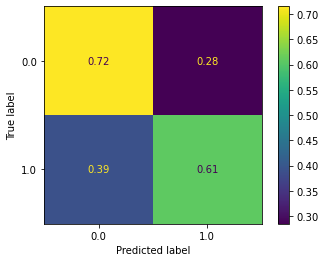

**************************************************

AdaBoostClassifier()
Accuracy Train: 66.28%
Accuracy Test:  68.62%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


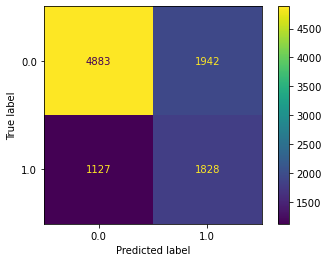

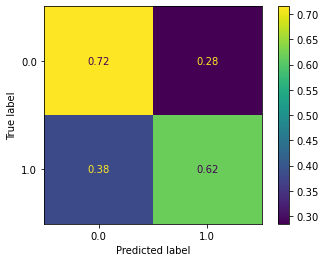

**************************************************

LinearSVC()
Accuracy Train: 49.82%
Accuracy Test:  69.40%


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


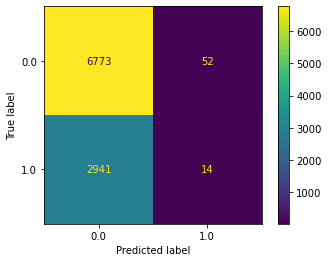

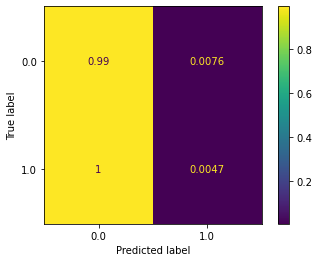

**************************************************



In [42]:
# Evaluate various models 
## Define list of models to be evaluated
models = []
models.append(LogisticRegression())
models.append(RidgeClassifier())
models.append(DecisionTreeClassifier(max_depth=7))
models.append(RandomForestClassifier(n_estimators=5, max_depth=7 ))
models.append(AdaBoostClassifier( ))
models.append(LinearSVC())
for model in models:
    # Train the model
    print(model)
    clf = model
    clf = clf.fit(X_train, y_train)
    
    # Show results/metrics
    from sklearn.metrics import accuracy_score
    print('Accuracy Train: {:.2%}'.format(accuracy_score(y_train, clf.predict(X_train))))
    print('Accuracy Test:  {:.2%}'.format(accuracy_score(y_test, clf.predict(X_test))))
    plot_confusion_matrix(clf, X_test, y_test) 
    plot_confusion_matrix(clf, X_test, y_test, normalize='true') 
    plt.show()
    print('*'*50+'\n')

__Observations:__  
    - After applying undersampling strategy we get better accuracy for most of the models trained.  
    - As tree based models and  ensembleds are performing better I will choose the simple decision tree.  
    - The reason for it is because I prefer to work with simpler models (also easy to explain) when the performance of a group of them are similar.

In [43]:
# Model selected
freq_model = models[2] ##Decision Tree

In [44]:
# Save model
with open('../obj/freq_model.pkl', 'wb') as handle:
    pickle.dump(freq_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Volume model

The target for this model is to predict the volume of sales we would expect for every customer if there was a sale in the month of prediction

In [45]:
data_bk = data.copy()

In [46]:
data = data_bk.copy()

In [47]:
# Define target of the model
data=data[data['TotalPrice']>0] ## Filter only when there was a sale
data['target'] = data['TotalPrice']

count    8.409000e+03
mean     8.815168e+02
std      5.140258e+03
min      1.421085e-14
25%      2.239000e+02
50%      3.652700e+02
75%      6.528000e+02
max      3.294942e+05
Name: target, dtype: float64

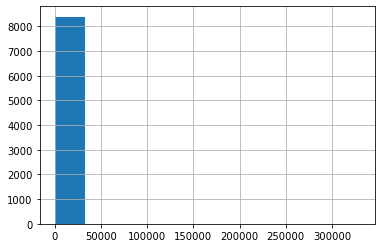

In [48]:
# Check distribution of the target
display(data['target'].describe())
data['target'].hist()
plt.show()

In [49]:

columns = ['sales_mean_6_m','last_sale','last_sale_over_6m_mean','sales_cadence',
           'months_from_last_sale','sales_cadence_deviation','last_sale_over_total']
X = data[columns]
y = data['target'].map(float)

In [50]:
# Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
X_train.shape

(6306, 7)

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

In [53]:
# Evaluate various models 
## Define list of models to be evaluated
models = []
models.append(LinearRegression(normalize=True, ))
models.append(DecisionTreeRegressor(max_depth=5, max_features=5 ))
models.append(RandomForestRegressor(n_estimators=4, max_depth=4 ))
models.append(AdaBoostRegressor( n_estimators=4, ))
for model in models:
    # Train the model
    print(model)
    clf = model
    clf = clf.fit(X_train, y_train)
    
    # Show results/metrics
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error Train: {:,.0f}'.format(mean_squared_error(y_train, clf.predict(X_train), squared=False)))
    print('mean_squared_error Test:  {:,.0f}'.format(mean_squared_error(y_test, clf.predict(X_test), squared=False)))
    plt.show()
    print('*'*50+'\n')

LinearRegression(normalize=True)
mean_squared_error Train: 3,842
mean_squared_error Test:  1,603
**************************************************

DecisionTreeRegressor(max_depth=5, max_features=5)
mean_squared_error Train: 1,287
mean_squared_error Test:  5,874
**************************************************

RandomForestRegressor(max_depth=4, n_estimators=4)
mean_squared_error Train: 2,635
mean_squared_error Test:  3,466
**************************************************

AdaBoostRegressor(n_estimators=4)
mean_squared_error Train: 1,555
mean_squared_error Test:  5,910
**************************************************



C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [54]:
#Compare distributions
y_train.describe()

count    6.306000e+03
mean     9.233560e+02
std      5.629644e+03
min      1.421085e-14
25%      2.254925e+02
50%      3.697100e+02
75%      6.622325e+02
max      3.294942e+05
Name: target, dtype: float64

In [55]:
pd.Series(models[2].predict(X_train)).describe()

count      6306.000000
mean        937.335791
std        4860.204646
min         433.296278
25%         433.296278
50%         433.296278
75%         433.296278
max      210919.075000
dtype: float64

In [56]:
# Model selected
vol_model = models[2]

__Observations:__  
    - This time I chose the RF Regressor because it shows similar performance over different training datasets.

In [57]:
# Save model
with open('../obj/vol_model.pkl', 'wb') as handle:
    pickle.dump(vol_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Combining both models

As we have Frequency and Volume, we can calculate the "Expected Sales" for every Customer multiplying the result of both models:  
- Expected Sale = (Probability of sale) * (Volume predicted)

In [58]:
data = data_bk.copy()

In [59]:
# Define target
data['target'] = data['TotalPrice']

In [60]:
columns = ['sales_mean_6_m','last_sale','last_sale_over_6m_mean','sales_cadence',
           'months_from_last_sale','sales_cadence_deviation','last_sale_over_total']
X = data[columns]
y = data['target'].map(float)

In [61]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<Figure size 720x360 with 0 Axes>

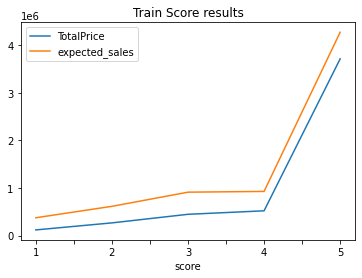

In [62]:
# Comparing Score vs real in train data
## Get results from models
X_train['freq'] = freq_model.predict_proba(X_train[columns])[:,1]
X_train['vol'] = vol_model.predict(X_train[columns])
X_train['expected_sales'] = X_train['freq']*X_train['vol']
X_train['score'] = pd.qcut(X_train['expected_sales'],
                          q = 5,
                          labels = [str(i) for i in range(1,6)] )
X_train['TotalPrice'] = y_train

#Score expected sales
to_plot = X_train.groupby('score').agg({'TotalPrice':'sum','expected_sales':'sum'})
plt.figure(figsize=(10,5))

#Plot results to compare real vs model
to_plot.plot()
plt.title('Train Score results')
plt.show()


In [63]:
# Bins for scoring new data
bins = [X_train['expected_sales'].min()] + list(X_train.groupby('score').agg({'expected_sales':'max'}).values.reshape(-1))[:-1] + [10000000000]

<Figure size 720x360 with 0 Axes>

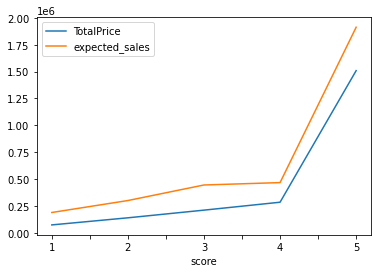

,TotalPrice,expected_sales
score,,
1,73880.60,1.893815e+05
2,139957.16,3.006275e+05
3,211300.41,4.452824e+05
4,284968.28,4.674398e+05
5,1508740.18,1.912345e+06


In [64]:
# Comparing Score in test data
## Get results from models
X_test['freq'] = freq_model.predict_proba(X_test[columns])[:,1]
X_test['vol'] = vol_model.predict(X_test[columns])
X_test['expected_sales'] = X_test['freq']*X_test['vol']

#Score expected sales
X_test['score'] = pd.cut(X_test['expected_sales'],
                          bins = bins,
                          labels = [str(i) for i in range(1,6)] )
X_test['TotalPrice'] = y_test

#Plot results to compare real vs model
to_plot = X_test.groupby('score').agg({'TotalPrice':'sum','expected_sales':'sum'})
plt.figure(figsize=(10,5))
to_plot.plot()
plt.show()
display(to_plot)

__Comments:__  
- As the results show, Customers with higher Scores buy more.
- The score performance is very similar when comparing Train and Test data
- Combining both models (frequency and volume) we can get a tool to prioritize Customers in the month based on the "Expected Sales".
- This excercise only asked for a model for predicting if there will be a sale or not. However, we could take the risk of focusing on frequent customers that buy small amounts.  
- Combining frequency and volume we can generate a better metric ("Expected sales") to focus or prioritize those Customers that will buy the biggest amount of our sales
    

In [65]:
# Save columns and bins for future prediction
with open('../obj/columns.pkl', 'wb') as handle:
    pickle.dump(columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../obj/bins.pkl', 'wb') as handle:
    pickle.dump(bins, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Explanation of the models

## Frequency model explanation

<AxesSubplot:xlabel='features', ylabel='importances'>

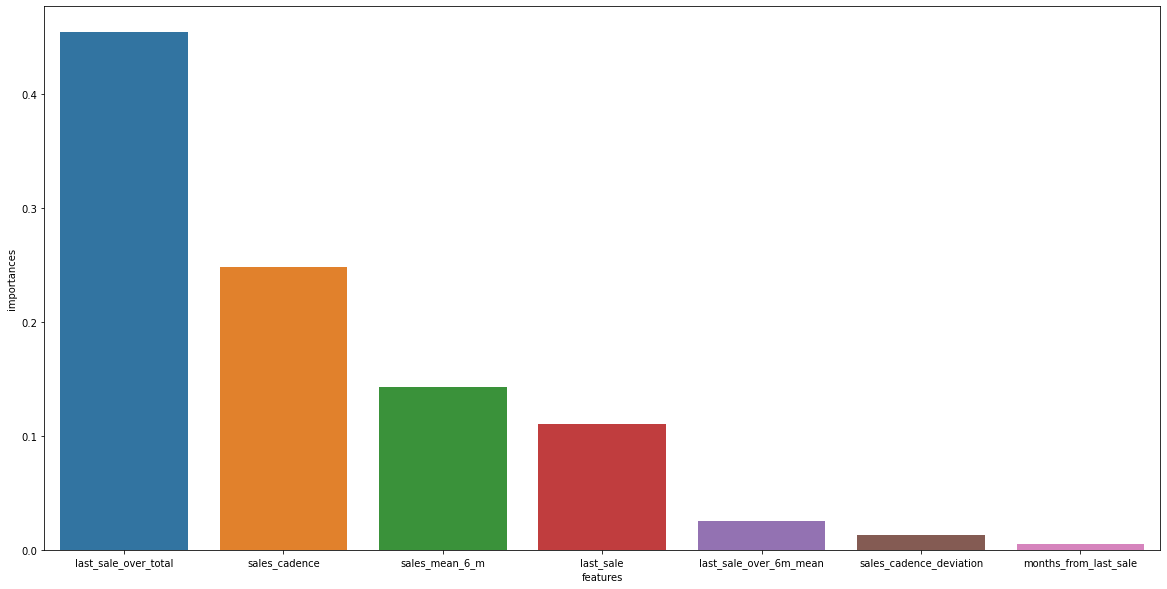

In [66]:
# Feature Importance
fi = pd.DataFrame()
fi['features'] = columns
fi['importances'] = freq_model.feature_importances_
fi.sort_values(by='importances', inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data = fi, x ='features', y ='importances' )

In [67]:
import shap

In [68]:
shap.initjs()

In [69]:
explainer = shap.TreeExplainer(freq_model)
shap_values = explainer.shap_values(X_train)

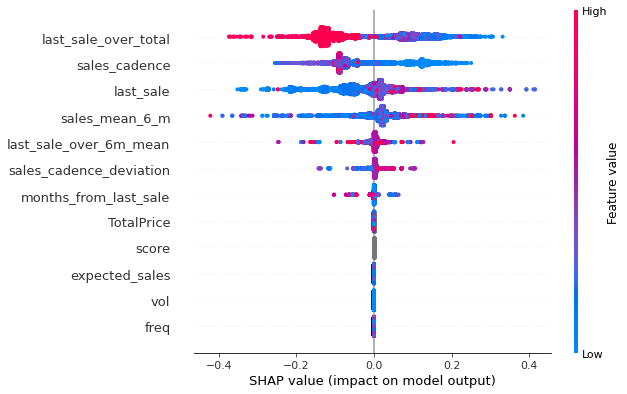

In [70]:
shap.summary_plot(shap_values[1], features=X_train, feature_names=X_train.columns, )


__Observations:__   
- The top 3 important features for the frequency model are: last_sale/Total , Sales cadence and amount of last sale.
- When the last sale over the total in the last 6 months is greater, the probability of getting a sale decreases.
- When the sales cadence (number of months between each sale mean) decreases the probability of getting a sale increases 

## Volume model explanation

<AxesSubplot:xlabel='features', ylabel='importances'>

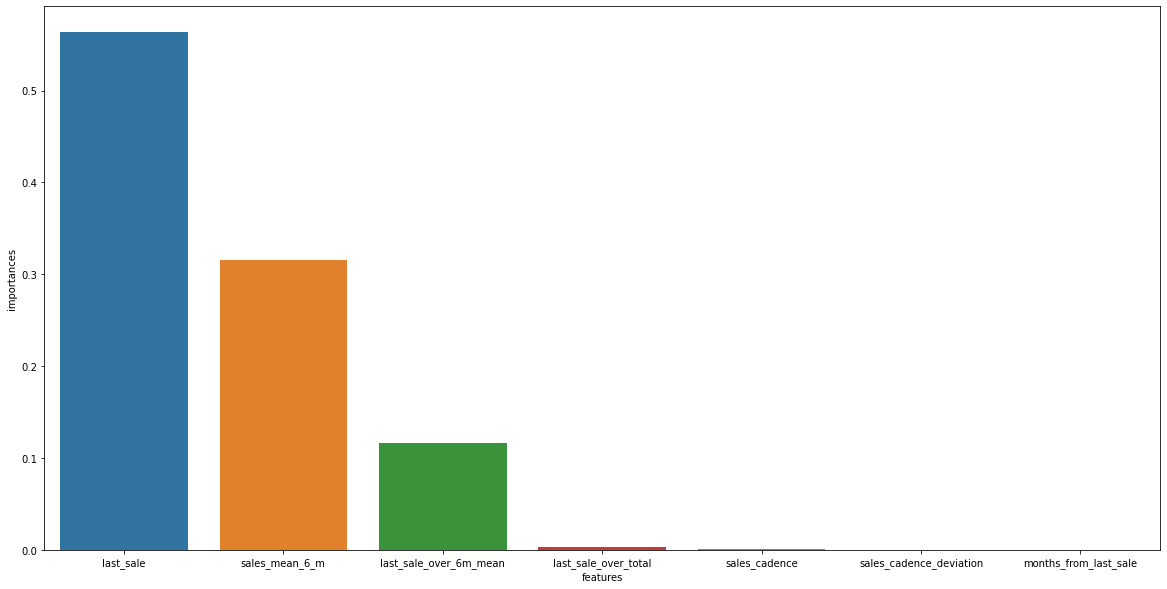

In [71]:
# Feature Importance
fi = pd.DataFrame()
fi['features'] = columns
fi['importances'] = vol_model.feature_importances_
fi.sort_values(by='importances', inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data = fi, x ='features', y ='importances' )

In [72]:
from sklearn.inspection import PartialDependenceDisplay

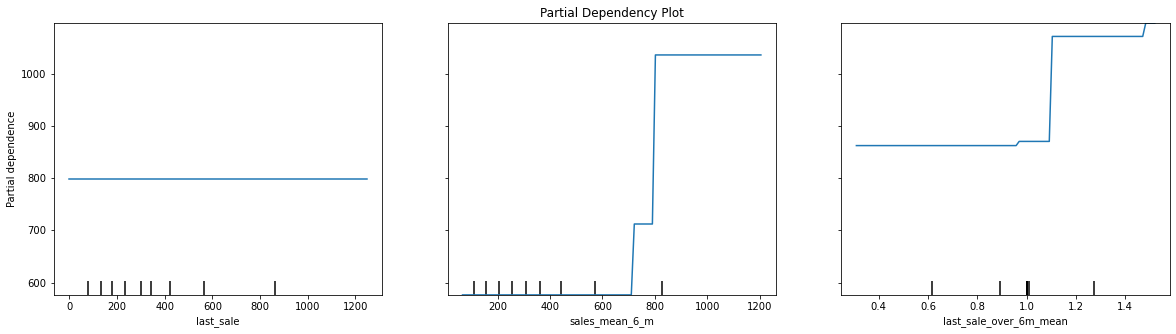

In [75]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(vol_model,
                                        X_test,
                                        features = ['last_sale','sales_mean_6_m', 'last_sale_over_6m_mean'],
                                        feature_names = columns,
                                        ax = ax, );

__Observations:__   
- The top 3 important features for the volume model are last_sale, sales_mean_6_m and the ratio between these two.  
- Partial dependence plots show that last sales move the value of prediction in both directions: positive and negative
- The expected sale increases when the sales mean in the last 6 months is greater than 700 but it keeps increasing only up to more than 800 USD.
- If the last sale was greater than the 6m mean (ratio>1) the expected sales amount increase a fixed amount and keeps the same until the ratio surpass 1.5